<a href="https://colab.research.google.com/github/vujjiniashrith/IOT_security/blob/main/Refined_autoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.impute import KNNImputer
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dense,ActivityRegularization
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_excel('combined_dataset.xlsx')
columns = df.columns
print(columns)
columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM']
df.drop(columns=columns_to_delete, inplace=True)
print(df.columns)

Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3', 'INOP_PLETH',
       'INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM'],
      dtype='object')
Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3'], dtype='object')


In [ ]:
#df = df.loc[(df != 0).all(axis=1)]

In [ ]:
df.shape

(87879, 7)

<AxesSubplot:>

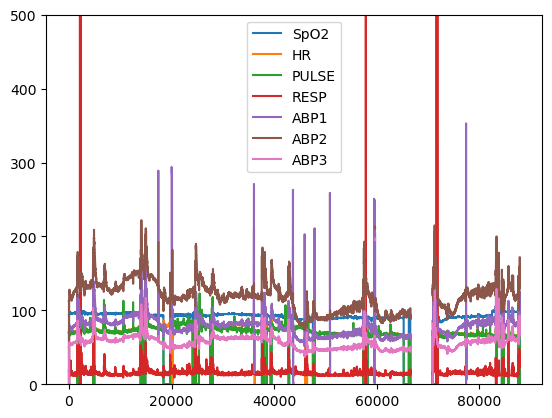

In [ ]:
df.plot(ylim=(0, 500), kind='line')

In [ ]:
subset = df.iloc[70000:70020]
print(subset)

       SpO2  HR  PULSE  RESP  ABP1  ABP2  ABP3
70000   NaN NaN    NaN   NaN   NaN   NaN   NaN
70001   NaN NaN    NaN   NaN   NaN   NaN   NaN
70002   NaN NaN    NaN   NaN   NaN   NaN   NaN
70003   NaN NaN    NaN   NaN   NaN   NaN   NaN
70004   NaN NaN    NaN   NaN   NaN   NaN   NaN
70005   NaN NaN    NaN   NaN   NaN   NaN   NaN
70006   NaN NaN    NaN   NaN   NaN   NaN   NaN
70007   NaN NaN    NaN   NaN   NaN   NaN   NaN
70008   NaN NaN    NaN   NaN   NaN   NaN   NaN
70009   NaN NaN    NaN   NaN   NaN   NaN   NaN
70010   NaN NaN    NaN   NaN   NaN   NaN   NaN
70011   NaN NaN    NaN   NaN   NaN   NaN   NaN
70012   NaN NaN    NaN   NaN   NaN   NaN   NaN
70013   NaN NaN    NaN   NaN   NaN   NaN   NaN
70014   NaN NaN    NaN   NaN   NaN   NaN   NaN
70015   NaN NaN    NaN   NaN   NaN   NaN   NaN
70016   NaN NaN    NaN   NaN   NaN   NaN   NaN
70017   NaN NaN    NaN   NaN   NaN   NaN   NaN
70018   NaN NaN    NaN   NaN   NaN   NaN   NaN
70019   NaN NaN    NaN   NaN   NaN   NaN   NaN


<AxesSubplot:>

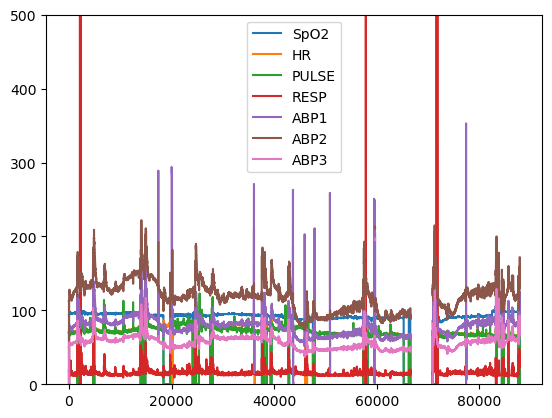

In [ ]:
df.plot(ylim=(0, 500), kind='line')

In [ ]:
df.shape

(87879, 7)

In [ ]:
nan_count = df.isna().any(axis=1).sum()
print(nan_count)

4677


In [ ]:
df.dropna( inplace = True)

In [ ]:
df.reset_index(drop = True, inplace = True)

<AxesSubplot:>

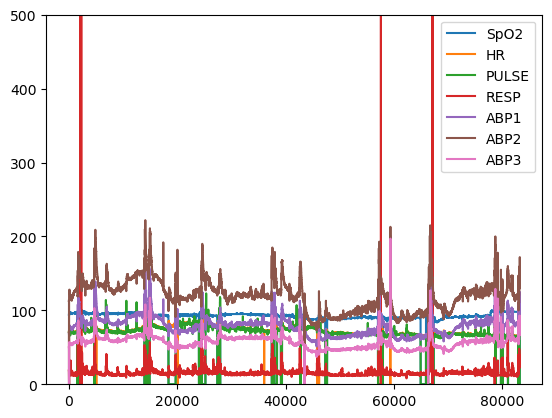

In [ ]:
df.plot(ylim=(0, 500), kind='line')

In [ ]:
df = df.loc[(df != 0).all(axis=1)]

In [ ]:
df.reset_index(drop = True, inplace = True)

<AxesSubplot:>

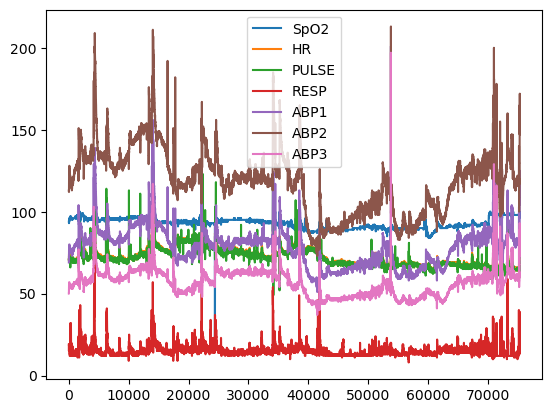

In [ ]:
df.plot(kind='line')

In [ ]:
df.shape

(75380, 7)

In [ ]:
scaler = StandardScaler()
data = scaler.fit_transform(df)

In [ ]:
len(data)*0.8

60304.0

In [ ]:
train = data[:60304]
test = data[60304:]

In [ ]:
lookback = 200
sequences = []


In [ ]:
for i in range(len(train)-lookback+1):
    sequence = data[i:i+lookback]
    sequences.append(sequence)


In [ ]:
sequences = np.array(sequences)

input_shape = (lookback,7)
latent_dim = 4

In [ ]:
# Define a custom loss function
def custom_loss(y_true, y_pred):
    mse_loss = keras.losses.mean_squared_error(y_true, y_pred)

    # Define a penalty for sudden jumps (adjust weight as needed)
    jump_penalty = 0.5  # Adjust the penalty weight
    jump_loss = keras.backend.mean(keras.backend.square(y_true - y_pred) * jump_penalty)

    # Combine MSE loss and jump penalty
    total_loss = mse_loss + jump_loss

    return total_loss

In [ ]:
input_layer = Input(shape = input_shape)


encoder = LSTM(latent_dim,kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01))(input_layer)

decoder = RepeatVector(lookback)(encoder)

decoder = LSTM(7, return_sequences=True)(decoder)

autoencoder = keras.Model(input_layer, decoder)
autoencoder.compile(optimizer ='adam',loss = custom_loss)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 7)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 4)                 192       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 200, 4)           0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 200, 7)            336       
                                                                 
Total params: 528
Trainable params: 528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.fit(sequences, sequences, epochs=20, batch_size=32)

Epoch 1/20
1879/1879 [==============================] - 223s 117ms/step - loss: 0.7305
Epoch 2/20
 640/1879 [=========>....................] - ETA: 2:26 - loss: 0.5229

In [ ]:
test_sequences = []
for i in range(len(test)-lookback+1):
    test_sequence = data[i:i+lookback]
    test_sequences.append(test_sequence)
test_sequences = np.array(test_sequences)

encoded_data_test = autoencoder.predict(test_sequences)


In [ ]:
test_sequences.shape

(14877, 200, 7)

In [ ]:
last_value_test = encoded_data_test[:,-1,:]
reshaped_data_test = last_value_test.reshape(-1, last_value_test.shape[-1])

In [ ]:
original_data_test = scaler.inverse_transform(reshaped_data_test)

In [ ]:
original_df_test = pd.DataFrame(original_data_test, columns=df.columns)

In [ ]:
input_test = scaler.inverse_transform(test)
input_df_test = pd.DataFrame(input_test,columns=df.columns)

In [ ]:
input_df_test.shape

(15076, 7)

In [ ]:
original_df_test.shape

(14877, 7)

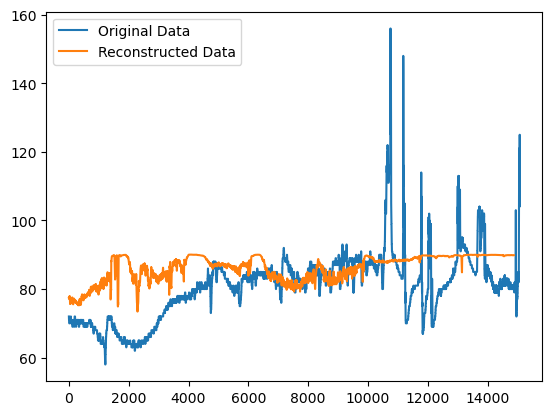

In [ ]:
plt.plot(input_df_test.ABP1, label='Original Data')
plt.plot(original_df_test.ABP1, label='Reconstructed Data')
plt.legend()
plt.show()

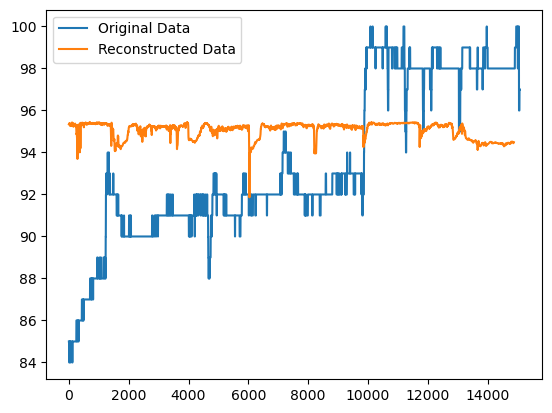

In [ ]:
plt.plot(input_df_test.SpO2, label='Original Data')
plt.plot(original_df_test.SpO2, label='Reconstructed Data')
plt.legend()
plt.show()

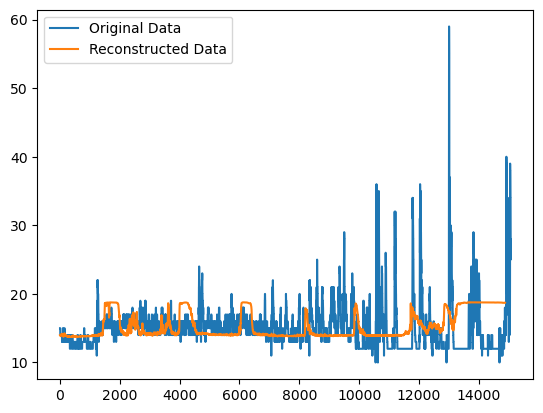

In [ ]:
plt.plot(input_df_test.RESP, label='Original Data')
plt.plot(original_df_test.RESP, label='Reconstructed Data')
plt.legend()
plt.show()

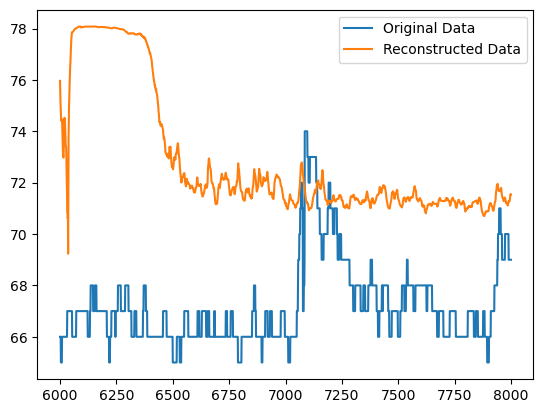

In [ ]:
plt.plot(input_df_test.PULSE[6000:8000], label='Original Data')
plt.plot(original_df_test.PULSE[6000:8000], label='Reconstructed Data')
plt.legend()
plt.show()

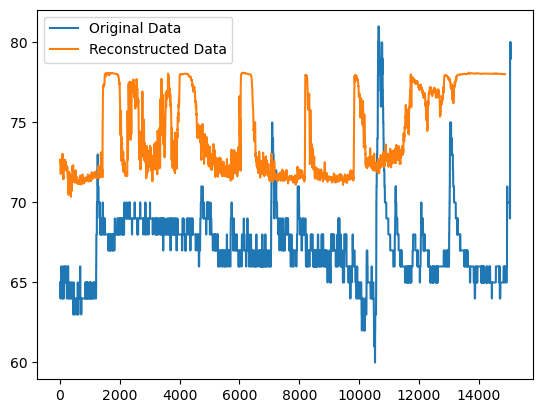

In [ ]:
plt.plot(input_df_test.HR, label='Original Data')
plt.plot(original_df_test.HR, label='Reconstructed Data')
plt.legend()
plt.show()

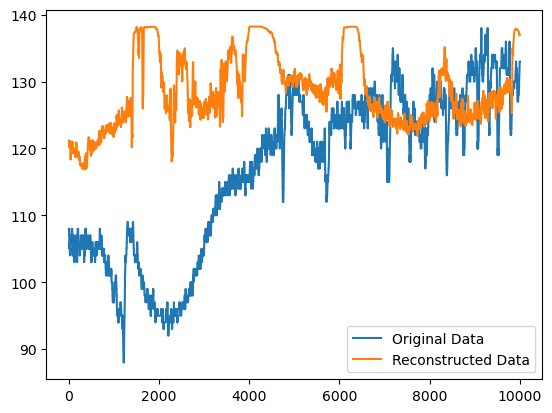

In [ ]:
plt.plot(input_df_test.ABP2[:10000], label='Original Data')
plt.plot(original_df_test.ABP2[:10000], label='Reconstructed Data')
plt.legend()
plt.show()

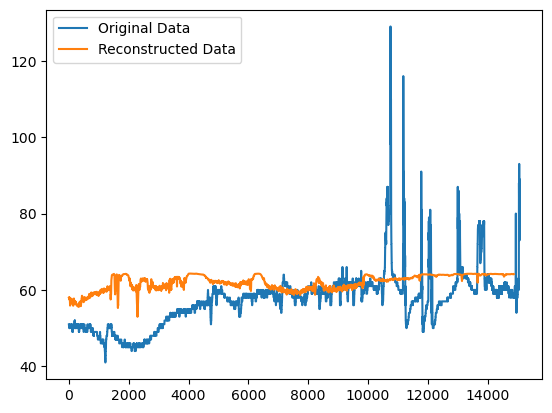

In [ ]:
plt.plot(input_df_test.ABP3, label='Original Data')
plt.plot(original_df_test.ABP3, label='Reconstructed Data')
plt.legend()
plt.show()

In [ ]:
encoded_data_train = autoencoder.predict(sequences)

In [ ]:
last_value_train = encoded_data_train[:,-1,:]
reshaped_data_train = last_value_train.reshape(-1, last_value_test.shape[-1])

In [ ]:
original_data_train = scaler.inverse_transform(reshaped_data_train)
original_df_train = pd.DataFrame(original_data_train, columns=df.columns)

In [ ]:
input_train = scaler.inverse_transform(train)
input_df_train = pd.DataFrame(input_train,columns=df.columns)

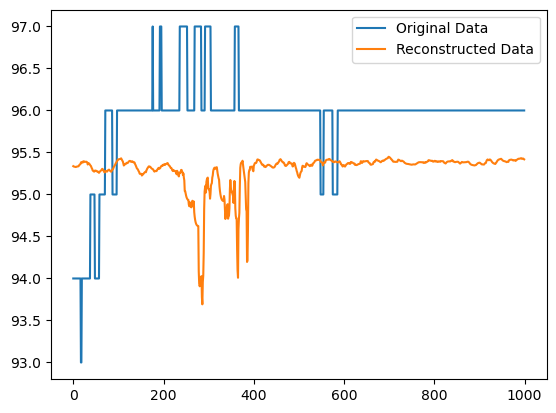

In [ ]:
plt.plot(input_df_train.SpO2[:1000], label='Original Data')
plt.plot(original_df_train.SpO2[:1000], label='Reconstructed Data')
plt.legend()
plt.show()

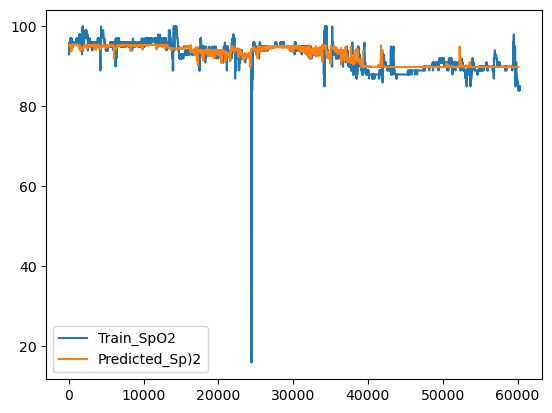

In [ ]:
plt.plot(input_df_train.SpO2, label='Train_SpO2')
plt.plot(original_df_train.SpO2, label='Predicted_Sp)2')
plt.legend()
plt.show()